Simple muon and neutrino flux calculation
-----------------------------------------

This notebook demonstrates the basic use case of the solver. It calculates the atmospheric lepton flux, taking most of the configuration values from the 'global' config file `mceq_config.py`. The interaction model and the primary cosmic ray flux model are selected during initialization.

In [1]:
#basic imports and ipython setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import matplotlib.pyplot as plt
import numpy as np
os.chdir('..')

#import solver related modules
from MCEq.core import MCEqRun
from mceq_config import config
#import primary model choices
import CRFluxModels as pm

Create an instance of an MCEqRun class. Most of its areguments are contained in the `config` dictionary from the `mceq_config` module. Look into or edit `mceq_config.py`.

If the initialization succeeds it will print out some information according to the debug level. 

In [2]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.1',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.Thunman,None),#(pm.HillasGaisser2012, "H3a"),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=80.0,
#expand the rest of the options from mceq_config.py
**config
)

InteractionYields::_load(): entering..
/afs/ifh.de/group/that/work-af/git/MCEq/data/SIBYLL21_yields.ppd
InteractionYields::_gen_index(): entering..
SIBYLL2.1 SIBYLL2.1
InteractionYields:set_interaction_model():: Model SIBYLL2.1 already loaded.
MCEqRun::_gen_list_of_particles():Generating particle list.
MCEqRun::_init_alias_tables():Initializing links to alias IDs.

Hadrons:

"p-bar", "p", "gamma", "n-bar", "n", "pi+", "pi-"

Mixed:

"K0L", "K+", "K-", "Lambda0-bar", "Lambda0", "Xi0-bar", "Xi0", "K0S", 
"Xi--bar", "Xi-", "Sigma--bar", "Sigma-", "Sigma+-bar", "Sigma+", "Omega--bar", "Omega-", 
"D+", "D-", "Ds+", "Ds-", "D0", "D0-bar", "XiC+-bar", "XiC+", 
"tau+", "tau-", "LambdaC+-bar", "LambdaC+", "XiC0-bar", "XiC0", "OmegaC0-bar", "OmegaC0", 
"pi0", "eta"

Resonances:

"Sigma0-bar", "Sigma0", "D*+", "D*-", "eta*", "jpsi", "phi", "SigmaC0-bar", 
"SigmaC0", "SigmaC+-bar", "SigmaC+", "SigmaC++-bar", "SigmaC++", "omega", "Xi*0-bar", "Xi*0", 
"Xi*--bar", "Xi*-", "SigmaC*0-bar", "SigmaC*0", 

__________

If everything succeeds than the last message should be something like

`MCEqRun::set_primary_model():  HillasGaisser2012 H3a`.

The spline interpolating the depth-density relation of an atmosphere will be caluclated and cached during the first run. 

Integrate
---------
Now, run the solve command to integrate the cascade equations starting from the top of the atmosphere
down to the observation level `h_obs` (see config).

In [3]:
mceq_run.solve()

MCEqRun::solve(): solver=euler and sparse=True
MCEqRun::_calculate_integration_path():
MCEqRun::_forward_euler(): Solver will perform 29342 integration steps.

MCEqRun::_forward_euler(): time elapsed during integration: 18.0652019978 sec


Retrieve results
----------------

In [4]:
#Power of energy to scale the flux
mag = 3

#obtain energy grid (nver changes) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

#Retrieve the flux at the surface by using the aliases which were listed in the
#output during the MCEqRun initialization. 
flux = {}
#_conv means conventional (mostly pions and kaons)
flux['mu_conv'] = (mceq_run.get_solution('conv_mu+', mag)
                   + mceq_run.get_solution('conv_mu-', mag))

# _pr means prompt (the mother of the muon had a critical energy
# higher than a D meson. Includes all charm and direct resonance
# contribution)
flux['mu_pr'] = (mceq_run.get_solution('pr_mu+', mag)
                 + mceq_run.get_solution('pr_mu-', mag))

# total means conventional + prompt
flux['mu_total'] = (mceq_run.get_solution('total_mu+', mag)
                    + mceq_run.get_solution('total_mu-', mag))

# same meaning of prefixes for muon neutrinos as for muons
flux['numu_conv'] = (mceq_run.get_solution('conv_numu', mag)
                     + mceq_run.get_solution('conv_antinumu', mag))

flux['numu_pr'] = (mceq_run.get_solution('pr_numu', mag)
                   + mceq_run.get_solution('pr_antinumu', mag))

flux['numu_total'] = (mceq_run.get_solution('total_numu', mag)
                      + mceq_run.get_solution('total_antinumu', mag))

# same meaning of prefixes for electron neutrinos as for muons
flux['nue_conv'] = (mceq_run.get_solution('conv_nue', mag)
                    + mceq_run.get_solution('conv_antinue', mag))

flux['nue_pr'] = (mceq_run.get_solution('pr_nue', mag)
                  + mceq_run.get_solution('pr_antinue', mag))

flux['nue_total'] = (mceq_run.get_solution('total_nue', mag)
                     + mceq_run.get_solution('total_antinue', mag))


# since there are no conventional tau neutrinos, prompt=total
flux['nutau_pr'] = (mceq_run.get_solution('total_nutau', mag)
                    + mceq_run.get_solution('total_antinutau', mag))

Plot with matplotlib
--------------------

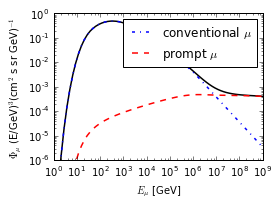

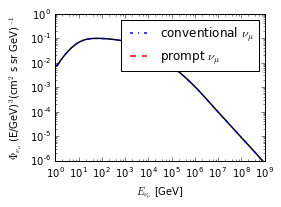

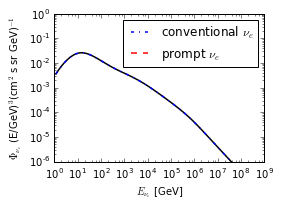

In [5]:
#get path of the home directory + Desktop
save_pdf = False
desktop = os.path.join(os.path.expanduser("~"),'Desktop')

for pref, lab in [('mu_',r'\mu'), ('numu_',r'\nu_\mu'), ('nue_',r'\nu_e')]:
    plt.figure(figsize=(4., 3))
    plt.loglog(e_grid, flux[pref + 'total'], color='k', ls='-', lw=1.5)
    plt.loglog(e_grid, flux[pref + 'conv'], color='b', ls='-.', lw=1.5,
               label=r'conventional ${0}$'.format(lab))
    plt.loglog(e_grid, flux[pref + 'pr'], color='r',ls='--', lw=1.5, 
               label='prompt ${0}$'.format(lab))
    plt.xlim(1,1e9)
    plt.ylim(1e-6,1)
    plt.xlabel(r"$E_{{{0}}}$ [GeV]".format(lab))
    plt.ylabel(r"$\Phi_{" + lab + "}$ (E/GeV)$^{" + str(mag) +" }$" + 
               "(cm$^{2}$ s sr GeV)$^{-1}$")
    plt.legend(loc='upper right')
    plt.tight_layout()
    if save_pdf: plt.savefig(os.path.join(desktop, pref + 'flux.eps'))

pref = 'nutau'
if np.any(flux[pref + '_pr']): #for models without prompt -> no nutau
    plt.figure(figsize=(4., 3))
    lab = r'\nu_\tau'
    plt.loglog(e_grid, flux[pref + '_pr'], color='k', ls='-', lw=1.5,
               label='prompt ${0}$'.format(lab))
    plt.xlim(1,1e9)
    plt.ylim(1e-8,1e-3)
    plt.xlabel(r"$E_{{{0}}}$ [GeV]".format(lab))
    plt.ylabel(r"$\Phi_{" + lab + "}$ (E/GeV)$^{" + str(mag) +" }$" + 
               "(cm$^{2}$ s sr GeV)$^{-1}$")
    plt.legend(loc='upper right')
    plt.tight_layout()
    if save_pdf: plt.savefig(os.path.join(desktop, pref + 'flux.eps'))

Save as in ASCII file for other types of processing
---------------------------------------------------

In [ ]:
np.savetxt(open(os.path.join(desktop, 'my_flux_calculation_decon.txt'),'w'),
zip(e_grid, 
    flux['mu_conv'],flux['mu_pr'],flux['mu_total'],
    flux['numu_conv'],flux['numu_pr'],flux['numu_total'],
    flux['nue_conv'],flux['nue_pr'],flux['nue_total'],
    flux['nutau_pr']),
fmt='%6.5E',
header=('lepton flux scaled with E**{0}. Order (E, mu_conv, mu_pr, mu_total, ' +
        'numu_conv, numu_pr, numu_total, nue_conv, nue_pr, nue_total, ' +
        'nutau_pr').format(mag)
)

In [7]:
mceq_run.pdg2pref[7213].inverse_decay_length(mceq_run.e_grid)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
np.sign(-13)